Importing Libraries

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [88]:
raw_apple = '63101000'     
maraschino_cherry = '63111010'     
margarine = '81102000'     
yeast = '75236000'         
raw_oyester = '26315100'   

thiamin = '404'                     
protein = '203'         
gadoleic_acid = '617'  
zinc = '309' 

Function for converting milligrams, micrograms to grams

In [89]:
def convert_to_grams(row):
    if row['Unit'] == 'mg':
        return row['Amount'] / 1000
    elif row['Unit'] == 'mcg':
        return row['Amount'] / 1000000
    elif row['Unit'] == 'g':
        return row['Amount']
    else:
        return 0

Function for calculating logarithmic standard deviation

In [90]:
def standard_deviation(data,nutrient):
    log_avg = 0
    log_avg_sq = 0
    c=0
    for j in data:
        if(j[1]==int(nutrient)):
            if((j[2]) == 0):
                c+=1
                continue
            log_avg += np.log(float(j[2]))
            log_avg_sq += np.log(float(j[2]))**2
            c+=1

    return ((log_avg_sq/c) - ((log_avg/c)**2))**0.5

Function for calculating mn

In [91]:
def mn_calculator(linear_average_conc,sn =1.298):
    mn = np.log(linear_average_conc) - (math.pow(sn,2))/2
    return mn

Function for calculating qn

In [92]:
def linear_average_concentration(data,nutrient):
    num=0
    den=0
    for i in data:
        if(i[1]==int(nutrient)):
            num+=i[2]
            den+=1
    return num/den


def qn_calculator(linear_conc, sn=1.298):
    mn = mn_calculator(0.000199695*1e3)
    logarithmic_conc = np.log(linear_conc)
    denominator = linear_conc * sn *np.sqrt(2*np.pi)
    numerator = 1/ (np.exp(((logarithmic_conc-mn)**2)/(2*(sn)**2)))
    
    
    return numerator/denominator

Function for pivoting the dataset

In [93]:
def pivot_dataset(df):
    df.drop(columns=["Nutrient Index", "Unit", "Decimal Places"])
    df = df[df["Nutrient Index"].isin([309, 404])]
    df["Amount"] = df.apply(convert_to_grams,axis=1)

    df = df.pivot_table(index=['Food Index', 'Food'], columns='Nutrient Index', values='Amount', aggfunc='sum').reset_index()
    df.columns = ['Food Index', 'Food', 'Zinc', 'Thiamin']
    
    return df

Function for calculating the skewness

In [94]:
#skewness
def skewness(data, nutrient):
    log_values = []
    n = 0
    for item in data:
        if item[1] == int(nutrient):
            value = item[2]
            if value != 0:
                log_values.append(np.log(value))
                n += 1
    if n < 3:
        return None  # Skewness is undefined for less than 3 data points

    mean = np.mean(log_values)
    std_dev = np.std(log_values, ddof=1)  # Use ddof=1 for sample standard deviation
    skewness = (n / ((n - 1) * (n - 2))) * np.sum(((log_values - mean) / std_dev) ** 3)
    return skewness


Loading both the days data and removing the rows which have baby food

In [95]:
first_day = pd.read_csv("../NHANES/NHANES Original/CSV/firstDay.csv")
first_day = first_day[first_day["DRABF"] != 1]
second_day = pd.read_csv("../NHANES/NHANES Original/CSV/secondDay.csv")
second_day = second_day[second_day["DRABF"] != 1]

Selecting the USDA food indices from both the days 

In [96]:
first_day = set(first_day["DR1IFDCD"].tolist())
second_day = set(second_day["DR2IFDCD"].tolist())

both_days = list(first_day) + list(second_day)
len(both_days)

8524

Loading the FNDDS and Flavonoids dataset, and creating the NHANES dataset (The part that the paper is observing)

In [97]:
FNDDS_df = pd.read_csv('CSVs/FNDDS.csv')
Flavonoids_df = pd.read_csv('CSVs/Flavonoids.csv')

NHANES_df = FNDDS_df[FNDDS_df["Food Index"].isin(both_days)]

Dropping the columns (irrelevant for the analysis)

In [98]:
FNDDS_df.drop(columns = ['From','To','Nutrient Code'], inplace=True)
Flavonoids_df.drop(columns = ['From','To','Nutrient Code'], inplace=True)

All nutrients present in "Raw Apple"

In [99]:
# figure1_a = FNDDS_df
figure1_a = pd.concat([FNDDS_df, Flavonoids_df], ignore_index=True)
figure1_a.drop(columns = ['Food','Nutrient Category'],inplace= True)
figure1_a['Amount'] = figure1_a.apply(convert_to_grams, axis = 1)
figure1_a = figure1_a[figure1_a['Food Index'] == 63101000]
figure1_a = figure1_a[figure1_a['Amount'] != 0].sort_values(by='Amount', ascending=False)
figure1_a 

,Food Index,Nutrient Index,Amount,Nutrient,Unit,Decimal Places
317595,63101000,255,85.560000,Water,g,2
317592,63101000,205,13.810000,Carbohydrate,g,2
317598,63101000,269,10.390000,"Sugars, total",g,2
317599,63101000,291,2.400000,"Fiber, total dietary",g,1
317590,63101000,203,0.260000,Protein,g,2
317591,63101000,204,0.170000,Total Fat,g,2
317604,63101000,306,0.107000,Potassium,mg,0
317654,63101000,646,0.051000,"Fatty acids, total polyunsaturated",g,3
317643,63101000,618,0.043000,18:2,g,3
317633,63101000,606,0.028000,"Fatty acids, total saturated",g,3


Plotting Figure 1a

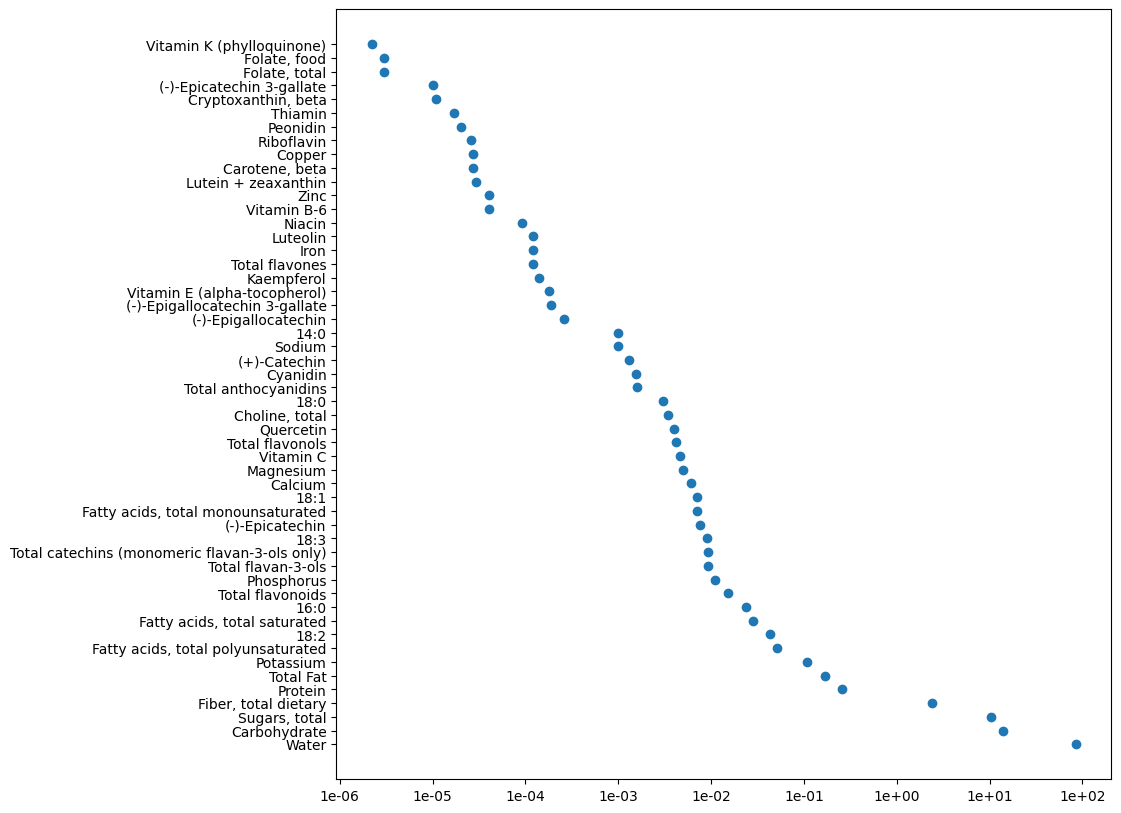

In [100]:
plt.figure(figsize=(10, 10))
plt.scatter(figure1_a['Amount'], figure1_a['Nutrient'], marker='o')
x_ticks = [10**i for i in range(-6, 3)]
plt.xscale('log')
plt.xticks(x_ticks, [f"{val:.0e}" for val in x_ticks])
plt.show()

Amount of "Zinc" and "Thiamin" present in the five foods : raw oysters, raw apple, maraschino cherries, yeast and margarine (Figure1b) 

In [101]:
figure1_b = FNDDS_df
figure1_b = figure1_b[figure1_b['Food Index'].isin([63101000, 63111010, 81102000, 75236000, 26315100])]
figure1_b = figure1_b[figure1_b['Nutrient Index'].isin([404, 309, 603, 217])]
figure1_b

,Food Index,Nutrient Index,Amount,Nutrient,Unit,Decimal Places,Food
92576,26315100,309,39.300,Zinc,mg,2,"~Oysters, raw~"
92589,26315100,404,0.018,Thiamin,mg,3,"~Oysters, raw~"
317606,63101000,309,0.040,Zinc,mg,2,"~Apple, raw~"
317619,63101000,404,0.017,Thiamin,mg,3,"~Apple, raw~"
319881,63111010,309,0.260,Zinc,mg,2,"~Cherries, maraschino~"
319894,63111010,404,0.000,Thiamin,mg,3,"~Cherries, maraschino~"
403796,75236000,309,7.940,Zinc,mg,2,~Yeast~
403809,75236000,404,10.990,Thiamin,mg,3,~Yeast~
428561,81102000,309,0.000,Zinc,mg,2,"~Margarine, NFS~"
428574,81102000,404,0.007,Thiamin,mg,3,"~Margarine, NFS~"


The observed part of the FNDDS dataset (should be 7253)

In [102]:
observed_df = FNDDS_df
observed_df = pivot_dataset(observed_df)

observed_df

C:\Users\SAUMIL\AppData\Local\Temp\ipykernel_25888\1893842401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amount"] = df.apply(convert_to_grams,axis=1)


,Food Index,Food,Zinc,Thiamin
0,11000000,"~Milk, human~",0.00017,0.000014
1,11100000,"~Milk, NFS~",0.00043,0.000040
2,11111000,"~Milk, cow's, fluid, whole~",0.00037,0.000046
3,11111100,"~Milk, cow's, fluid, whole, low-sodium~",0.00038,0.000020
4,11111150,"~Milk, calcium fortified, cow's, fluid, whole~",0.00037,0.000046
...,...,...,...,...
7248,94100200,"~Water, bottled, sweetened, with low or no cal...",0.00000,0.000000
7249,94100300,"~Water, fruit flavored, sweetened, with high f...",0.00032,0.000000
7250,94210100,~Propel Water~,0.00000,0.000000
7251,94210200,~Glaceau Water~,0.00032,0.000000


Observed part without the foods consumed by babies (should be 4889)

In [103]:
NHANES_df = pivot_dataset(NHANES_df)
NHANES_df

C:\Users\SAUMIL\AppData\Local\Temp\ipykernel_25888\1893842401.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amount"] = df.apply(convert_to_grams,axis=1)


,Food Index,Food,Zinc,Thiamin
0,11100000,"~Milk, NFS~",0.00043,0.000040
1,11111000,"~Milk, cow's, fluid, whole~",0.00037,0.000046
2,11111160,"~Milk, calcium fortified, cow's, fluid, 1% fat~",0.00042,0.000020
3,11111170,"~Milk, calcium fortified, cow's, fluid, skim o...",0.00040,0.000036
4,11112110,"~Milk, cow's, fluid, 2% fat~",0.00048,0.000039
...,...,...,...,...
4963,94100200,"~Water, bottled, sweetened, with low or no cal...",0.00000,0.000000
4964,94100300,"~Water, fruit flavored, sweetened, with high f...",0.00032,0.000000
4965,94210100,~Propel Water~,0.00000,0.000000
4966,94210200,~Glaceau Water~,0.00032,0.000000


In [104]:
data = FNDDS_df.values.tolist()

In [105]:
qn_calculator(1e-3)

0.8518004848963976

In [106]:

print(standard_deviation(data,thiamin))   #1.26543225 is the standard deviation acc to 4889 foods
print(standard_deviation(data,zinc))   #1.34545079 is the standard deviation acc to 4889 foods
print(standard_deviation(data,protein))   #1.34357727 is the standard deviation acc to 4889 foods
print(standard_deviation(data,gadoleic_acid))   #2.1041791 is the standard deviation acc to 4889 foods


# data

1.2960681729618984
1.2987449041275738
1.3200769941915813
2.009582874180106


In [107]:
l = np.array([standard_deviation(data,thiamin),standard_deviation(data,zinc),standard_deviation(data,protein),standard_deviation(data,gadoleic_acid)])
# avg = (standard_deviation(data,thiamin)+standard_deviation(data,zinc)+standard_deviation(data,protein)+standard_deviation(data,gadoleic_acid))/4
avg = np.mean(l)
sd = np.std(l)
print(sd)
print(avg)
print(l)

print("standard deviation of 4 nutrients: "+str(avg)+"+-"+str(sd))  #acc to data it is 1.66+-0.39
# avg

0.30525100875291283
1.48111823636529
[1.29606817 1.2987449  1.32007699 2.00958287]
standard deviation of 4 nutrients: 1.48111823636529+-0.30525100875291283


In [108]:
l=np.array([1.26543225,1.34545079,1.34357727,2.1041791])
avg = np.mean(l)
sd = np.std(l)
print(sd)
print(avg)

print("sd of 4 nutrients: "+str(avg)+"+-"+str(sd))  #acc to data it is 1.66+-0.39           


0.3418875172801219
1.5146598525
sd of 4 nutrients: 1.5146598525+-0.3418875172801219


In [109]:
print(skewness(data,thiamin))       #-0.035609511 is the skewness acc to 4889 foods
print(skewness(data,zinc))          #-0.445958592 is the skewness acc to 4889 foods
print(skewness(data,protein))       #-1.108838677 is the skewness acc to 4889 foods
print(skewness(data,gadoleic_acid)) #-1.094805201 is the skewness acc to 4889 foods


# A negative skewness value indicates that the distribution is skewed to the left, 
# with the tail on the left side of the distribution being longer or fatter compared to the right side.


-0.06719423364617477
-0.4654347450506087
-1.0459089614111048
-1.0803797854093047
